<a href="https://colab.research.google.com/github/giabb/thesimpsons-character-recognizer/blob/main/TheSimpsons_Character_Recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Giovanbattista Abbate - [@giabb](https://github.com/giabb)
#Vision and Perception Project
#"Sapienza" Università di Roma
#Spring Semester, 2020


##Import

In [ ]:
import os
import os.path
import datetime

import numpy as np
from math import ceil
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pickle

import tensorflow as tf
if not tf.test.gpu_device_name():
  print("Install GPU version of TF to get faster results")
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, GlobalMaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2, VGG16
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint

from skimage import io
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from google.colab import drive
drive.mount('/content/drive')

##Download dataset from Kaggle

In [ ]:
'''
You need to upload your own kaggle.json file
Check https://www.kaggle.com/general/74235 for more info
'''

#Set Kaggle, download and unzip the dataset
!pip install -q kaggle
!mkdir ~/.kaggle 
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d alexattia/the-simpsons-characters-dataset
!unzip -o '/content/the-simpsons-characters-dataset.zip' -d '/content/simpsonData' > /dev/null

 99% 1.07G/1.08G [00:12<00:00, 40.7MB/s]
100% 1.08G/1.08G [00:12<00:00, 93.9MB/s]


##My Model

![If you are seeing this, there is a problem in the image, direct link: https://github.com/giabb/the-simpsons-character-recognizer/blob/main/img/mymodel.png?raw=true](https://github.com/giabb/the-simpsons-character-recognizer/blob/main/img/mymodel.png?raw=true)

###Creating dictionaries

In [ ]:
#Reducing dataset only to classes with more than 300 elements
path = '/content/simpsonData/simpsons_dataset'
folderList = []

count = 0
for folderName in os.listdir(path):
  countFolder = 0
  for f in os.listdir(path+'/'+folderName):
    countFolder += 1
  if countFolder >= 300:
    count += countFolder
    folderList.append(folderName)

num_classes = len(folderList)

#Creating dictionaries for classes
d = {}
drev = {}
for ind, elem in enumerate(folderList):
  d1 = {elem:ind}
  d2 = {ind:elem}
  d.update(d1)
  drev.update(d2)

###Preprocessing



####Generating training and test set
Needed only the first time

In [ ]:
#Generating Training Set
img_size = 64

x_train = []
y_train = []

for folderName in os.listdir(path):
  if folderName in folderList:
    path2 = path+'/'+folderName
    for f in os.listdir(path2):
      pathfile = path2+'/'+f
      x_train.append(resize(io.imread(pathfile),(img_size,img_size)))
      y_train.append(d[folderName])
    print('ok')

x_train = np.asarray(x_train).astype('float32')
y_train = np.asarray(y_train)
y_train = tf.keras.utils.to_categorical(y_train, num_classes)

In [ ]:
#Generating Test Set
x_test = []
y_test = []

img_size = 64

test_path = '/content/simpsonData/kaggle_simpson_testset/kaggle_simpson_testset'
for fileName in os.listdir(test_path):
  pathfile = test_path+'/'+fileName
  fileName = (fileName.split('_'))
  str_file = ''
  for f in fileName[:-1]:
    str_file = str_file+f+'_'
  if str_file[:-1] in folderList:
    x_test.append(resize(io.imread(pathfile),(img_size,img_size)))
    y_test.append(str(d[str_file[:-1]]))
    
x_test = np.asarray(x_test).astype('float32')
y_test = np.asarray(y_test)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

###Model Structure

In [ ]:
#Custom net
model = Sequential()

model.add(Conv2D(32, (3,3), activation = 'relu', padding='same', input_shape = (64,64,3)))
model.add(Conv2D(32, (3,3),activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2),strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3),activation='relu', padding='same'))
model.add(Conv2D(64, (3,3),activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2),strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model resetted
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 1

###Splitting training set and defining data generator with data augmentation

In [ ]:
BATCH = 64

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=1)

datagen = ImageDataGenerator(#width_shift_range = 0.1, 
                             #height_shift_range = 0.1,  
                             #horizontal_flip = True, 
                             #vertical_flip = True,
                             zoom_range=0.2, 
                             shear_range=0.2,
                             rotation_range=30
                             ) 

train_generator = datagen.flow(x_train,
                               y_train,
                               batch_size=BATCH
                               )

###Compiling the model

In [ ]:
opt = tf.keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

now = datetime.datetime.now()
date = str(now.day)+str(now.month)+str(now.year)+'_'+str(now.hour)+str(now.minute)+str(now.second)
dir = '/'+date+'/logs'
call_tb = tf.keras.callbacks.TensorBoard(log_dir=dir)

###Training the model

In [ ]:
EPOCHS = 200

model.fit(train_generator,
          epochs = EPOCHS,
          steps_per_epoch = len(x_train) // BATCH,
          validation_data = (x_val, y_val),
          validation_steps = len(x_val) // BATCH,
          shuffle=True,
          callbacks=[call_tb],
          verbose=1)

model.save('/'+date+'/weigths')

Epoch 1/200
241/241 [==============================] - 28s 117ms/step - loss: 2.5588 - accuracy: 0.2102 - val_loss: 2.2129 - val_accuracy: 0.3473
Epoch 2/200
241/241 [==============================] - 27s 112ms/step - loss: 2.1583 - accuracy: 0.3588 - val_loss: 1.8949 - val_accuracy: 0.4737
Epoch 3/200
241/241 [==============================] - 27s 112ms/step - loss: 1.9657 - accuracy: 0.4154 - val_loss: 1.6926 - val_accuracy: 0.5328
Epoch 4/200
241/241 [==============================] - 27s 112ms/step - loss: 1.8352 - accuracy: 0.4660 - val_loss: 1.5800 - val_accuracy: 0.5716
Epoch 5/200
241/241 [==============================] - 27s 113ms/step - loss: 1.7126 - accuracy: 0.4937 - val_loss: 1.4556 - val_accuracy: 0.5985
Epoch 6/200
241/241 [==============================] - 27s 113ms/step - loss: 1.6115 - accuracy: 0.5255 - val_loss: 1.3580 - val_accuracy: 0.6263
Epoch 7/200
241/241 [==============================] - 27s 113ms/step - loss: 1.5165 - accuracy: 0.5554 - val_loss: 1.2835 -

###Evaluating the model

In [ ]:
#Make prediction
y_pred = model.predict(x_test, batch_size=64, verbose=1)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)
label_array = []
for i in range(19):
  label_array.append(drev[i])
print(classification_report(y_test, y_pred, target_names=label_array))

##VGG-16 Model

(I used 300x300 imgs)
![If you are seeing this, there is a problem in the image, direct link: https://github.com/giabb/the-simpsons-character-recognizer/blob/main/img/vgg16.png?raw=true](https://github.com/giabb/the-simpsons-character-recognizer/blob/main/img/vgg16.png?raw=true)

###Preprocessing
Different from the previous since 300x300 images are too big to fit in a single array

In [ ]:
#Creating pandas dataframe to store dataset
imsize = 300

path = '/content/simpsonData/simpsons_dataset'
data_dict = {}
target_labels_list = []
image_path_list = []

for folderName in os.listdir(path):
  if folderName in folderList:
    path2 = path+'/'+folderName
    for f in os.listdir(path2):
      label = folderName
      image_path = path2+'/'+f
      target_labels_list.append(label)
      image_path_list.append(image_path)
                
data_dict["label"] = target_labels_list
data_dict["image_path"] = image_path_list
input_df = pd.DataFrame(data_dict)

In [ ]:
#Splitting training and validation dataframe
train_df, val_df = train_test_split(input_df, test_size=0.2)

###Model structure
Some of the weights of the net will be frozen

In [ ]:
base_vgg16_model = VGG16(weights='imagenet',include_top=False, input_shape=(imsize,imsize,3))

base_vgg16_model.trainable = True
set_trainable = False
for layer in base_vgg16_model.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
      
model = Sequential()
model.add(base_vgg16_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 9, 9, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_5 (Dense)              (None, 19)                9747      
Total params: 15,249,747
Trainable params: 13,514,259
Non-trainable params: 1,735,488
_________________________________________________________________


###Data generators and data augmentation
In addition to the previous one, this one implements CutOff regularization



In [ ]:
#Function to implement cutoff regularization
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()
        if p_1 > p:
            return input_img
        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)
            if left + w <= img_w and top + h <= img_h:
                break
        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)
        input_img[top:top + h, left:left + w, :] = c
        return input_img
    return eraser

In [ ]:
BATCH = 64

datagen_transfer_train = ImageDataGenerator(#width_shift_range = 0.1, 
                                            #height_shift_range = 0.1,  
                                            #horizontal_flip = True, 
                                            #vertical_flip = True,
                                            #zoom_range=0.2, 
                                            shear_range=0.2,
                                            rotation_range=30,
                                            validation_split=0.2,
                                            preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=True)
                                            ) 

datagen_transfer_val = ImageDataGenerator()

train_transfer = datagen_transfer_train.flow_from_dataframe(train_df,
                                                            x_col='image_path',
                                                            y_col='label',
                                                            class_mode='categorical',
                                                            target_size=(imsize, imsize), 
                                                            batch_size=BATCH
                                                            )

val_transfer = datagen_transfer_val.flow_from_dataframe(val_df,
                                                        x_col='image_path',
                                                        y_col='label',
                                                        class_mode='categorical',
                                                        target_size=(imsize, imsize), 
                                                        batch_size=BATCH
                                                        )


Found 15441 validated image filenames belonging to 19 classes.
Found 3861 validated image filenames belonging to 19 classes.


###Compiling the model

In [ ]:
model.compile(tf.keras.optimizers.Adam(lr = 0.0001, decay = 0.002, epsilon = 1e-08), 
              loss='categorical_crossentropy', 
              metrics=['accuracy']) 

now = datetime.datetime.now()
date = str(now.day)+str(now.month)+str(now.year)+'_'+str(now.hour)+str(now.minute)+str(now.second)
dir = '/TRANSFER_'+date+'/logs'
wd = '/TRANSFER_'+date+'/bestckpt.h5'

earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, min_delta=1e-4, mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')
model_chk = ModelCheckpoint(monitor='val_loss', filepath=wd, save_best_only=True, save_weights_only=True, mode='min')
call_tb = TensorBoard(log_dir = dir)

callbacks = [call_tb, earlystop, model_chk, reduce_lr_loss]

###Training the model

In [ ]:
EPOCHS = 100

model.fit(train_transfer,
          epochs = EPOCHS,
          steps_per_epoch =  0.8 * count // BATCH,
          validation_data = val_transfer,
          validation_steps = 0.2 * count // BATCH,
          shuffle=True,
          callbacks=callbacks,
          verbose=1)

model.save('/TRANSFER_'+date+'/weights')

###Evaluating the model

In [ ]:
#Creating pandas ataframe to store test set
imsize = 300

path = '/content/simpsonData/kaggle_simpson_testset/kaggle_simpson_testset'
data_dict = {}
target_labels_list = []
image_path_list = []
folderList = ['bart_simpson', 'moe_szyslak', 'abraham_grampa_simpson', 'comic_book_guy', 'lisa_simpson', 'charles_montgomery_burns', 'milhouse_van_houten', 'krusty_the_clown', 'chief_wiggum', 'sideshow_bob', 'nelson_muntz', 'marge_simpson', 'homer_simpson', 'principal_skinner', 'edna_krabappel', 'ned_flanders', 'apu_nahasapeemapetilon', 'lenny_leonard', 'kent_brockman']

for fileName in os.listdir(path):
  path2 = path+'/'+fileName
  fileName = (fileName.split('_'))
  str_file = ''
  for f in fileName[:-1]:
    str_file = str_file+f+'_'
  if str_file[:-1] in folderList:
    label = str_file[:-1]
    target_labels_list.append(label)
    image_path_list.append(path2)
                
data_dict["label"] = target_labels_list
data_dict["image_path"] = image_path_list
test_df = pd.DataFrame(data_dict)

In [ ]:
datagen_test = ImageDataGenerator()

test_transfer = datagen_test.flow_from_dataframe(test_df,
                                                 x_col='image_path',
                                                 y_col='label',
                                                 class_mode='categorical',
                                                 target_size=(imsize, imsize),
                                                 shuffle = False
                                                 )


Found 940 validated image filenames belonging to 19 classes.


In [ ]:
img_test = []
y_test = []

for i, batch in enumerate(test_transfer):
  if i == 30:
    break
  for bp, bt in zip(batch[0],batch[1]):
    img_test.append(bp)
    y_test.append(bt)

img_test = np.asarray(img_test)
y_test = np.asarray(y_test)
y_test = np.argmax(y_test, axis = 1)

##Results

In [ ]:
#Make prediction
y_pred = model.predict(img_test, batch_size=64, verbose=1)
y_pred = np.argmax(y_pred, axis = 1)
label_array = []
for i in range(19):
  label_array.append(drev[i])
print(classification_report(y_test, y_pred, target_names=label_array))

15/15 [==============================] - 20s 1s/step
                          precision    recall  f1-score   support

  abraham_grampa_simpson       1.00      0.96      0.98        48
  apu_nahasapeemapetilon       0.96      1.00      0.98        50
            bart_simpson       0.91      1.00      0.95        50
charles_montgomery_burns       0.92      0.94      0.93        48
            chief_wiggum       0.98      1.00      0.99        50
          comic_book_guy       0.98      1.00      0.99        49
          edna_krabappel       1.00      0.96      0.98        50
           homer_simpson       0.94      1.00      0.97        50
           kent_brockman       0.98      0.98      0.98        50
        krusty_the_clown       0.98      0.94      0.96        50
           lenny_leonard       1.00      0.90      0.95        50
            lisa_simpson       0.98      0.98      0.98        50
           marge_simpson       1.00      0.98      0.99        50
     milhouse_van_hout

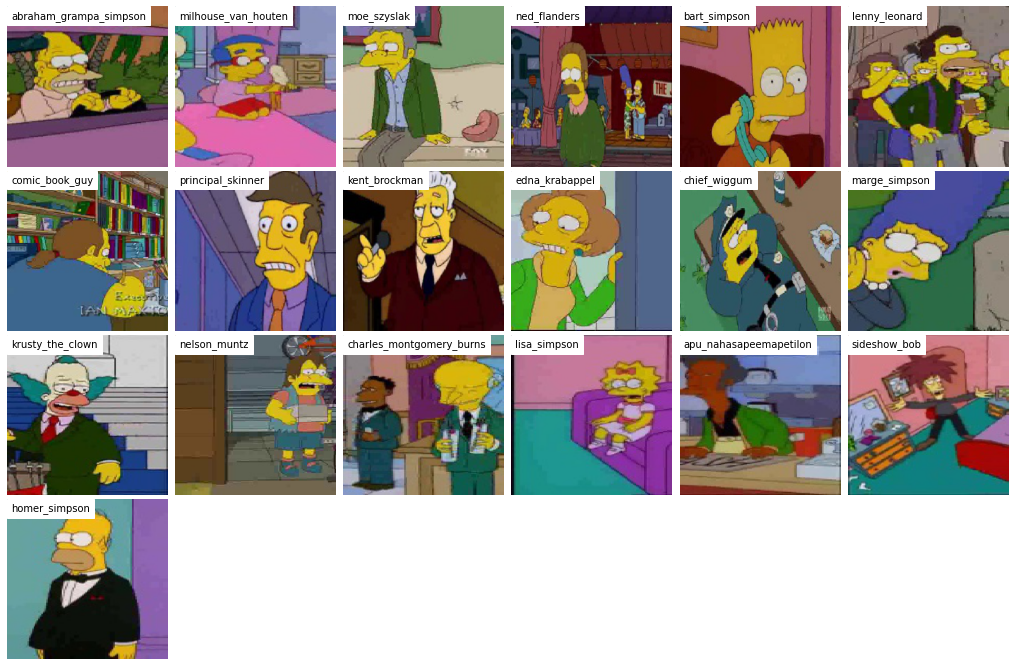

In [ ]:
appeared_lab = []
appeared_img = []
for i in range(len(y_test)):
  if y_pred[i] not in appeared_lab:
    appeared_lab.append(y_pred[i])
    appeared_img.append(img_test[i]/255.)

fig=plt.figure(figsize=(18, 12))
gs1 = gridspec.GridSpec(4, 6)
gs1.update(wspace=0.025, hspace=0.025)
for i, img in zip(range(24),appeared_img):
    ax = fig.add_subplot(gs1[i])
    t = ax.text(7, 22, drev[appeared_lab[i]])
    t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))
    plt.imshow(img)
    plt.axis('off')
plt.savefig("test.png", bbox_inches='tight')
plt.show()